<center><h2>ALTeGraD 2024<br>Lab Session 2: Transfer learning for NLP</h2> 15 / 10 / 2024<br> Dr. G. Shang, Y. Zhang<br><br>


<b>Student name:</b> [Delavande Julien]

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 22, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntokens, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model=nhid, nhead=nhead, dim_feedforward=nhid) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src) #fill me
        output = self.transformer_encoder(src, src_mask) #fill me
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)#fill me
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout) #fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask) #fill me
        # classifier model
        output = self.classifier(x)#fill me
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


In [13]:
V = ntokens
d = nhid
print(d)


print('For language modelling: ', 2*V*d + nlayers*(6*d**2 + 4*d))
print('For binary classification: ', 2*2*d + nlayers*(6*d**2 + 4*d))

200
For language modelling:  20963600
For binary classification:  964000


## Vocabulary and Tokenization

In [5]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2024-10-21 15:57:57--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.03s   

2024-10-21 15:57:58 (21.7 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [6]:
path_vocab = "dict.txt"
with open(path_vocab, "r") as f:
  for idx, line in enumerate(f):
    if idx < 4:
      print(idx)


0
1
2
3


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] =  idx + 4

ind2token = {ind:token for token, ind in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]]
        source_sequence += [
            self.token2ind.get(token, self.token2ind["<oov>"]) for token in sequence
        ]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1] #fill me
        output = output.view(-1, output.shape[-1])
        target =  data[1].view(-1) #fill me
        target = target.to(device)
        loss =  nn.CrossEntropyLoss()(output, target) #fill me, Cross entropy check next cells
        #fill me step 3
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [10]:
ntokens = len(ind2token) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2024-10-21 15:58:09--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.05s   

2024-10-21 15:58:09 (207 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [ ]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling", # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 2.78416 | ppl   16.186
| epoch   1 |  1000/ 3125 steps | loss 2.65183 | ppl   14.180
| epoch   1 |  1500/ 3125 steps | loss 2.54857 | ppl   12.789
| epoch   1 |  2000/ 3125 steps | loss 2.47751 | ppl   11.912
| epoch   1 |  2500/ 3125 steps | loss 2.45565 | ppl   11.654
| epoch   1 |  3000/ 3125 steps | loss 2.42962 | ppl   11.355
| epoch   2 |   500/ 3125 steps | loss 2.29825 | ppl    9.957
| epoch   2 |  1000/ 3125 steps | loss 2.30863 | ppl   10.061
| epoch   2 |  1500/ 3125 steps | loss 2.23081 | ppl    9.307
| epoch   2 |  2000/ 3125 steps | loss 2.27221 | ppl    9.701
| epoch   2 |  2500/ 3125 steps | loss 2.24798 | ppl    9.469
| epoch   2 |  3000/ 3125 steps | loss 2.21544 | ppl    9.165


## Text Generation


In [14]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2024-10-21 16:00:16--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   379MB/s    in 0.2s    

2024-10-21 16:00:20 (379 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-14-76a40ce8b80e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

<All keys matched successfully>

In [15]:
# !pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2024-10-21 16:00:23--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-10-21 16:00:23 (46.4 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [16]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = next_token_ind = torch.argmax(out[-1, 0, :]).item() #fill me
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    model.eval()
    generated_tokens = []

    # Encode the initial sentence
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces if el in token2ind]

    for _ in range(max_len):

        source_tensor = torch.tensor(source).to(device).unsqueeze(1)  # Shape: [sequence_length, 1]

        src_mask = model.base.generate_square_subsequent_mask(source_tensor.size(0)).to(device)


        out = model(source_tensor, src_mask)

        next_token_ind = torch.argmax(out[-1, 0, :]).item()


        if next_token_ind == token2ind['<eos>']:
            break

        # Ajouter le token généré à la séquence
        source.append(next_token_ind)
        generated_tokens.append(next_token_ind)

    # Décoder les tokens en texte
    generated_text = s.decode_pieces([ind2token[tok] for tok in generated_tokens])

    return generated_text


In [26]:
sent = "Bonjour je suis"
infer_next_tokens(sent)

'un peu plus loin.'

### Supervised task

In [27]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2024-10-21 16:03:31--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.02s   

2024-10-21 16:03:31 (58.1 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2024-10-21 16:03:31--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent,

In [28]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            src_mask = model.base.generate_square_subsequent_mask(inputs.size(0)).to(device)
            outputs = model(inputs, src_mask)
            outputs = outputs[-1]
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy


In [29]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [30]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.80000 | ppl    2.226
| epoch   1 |   100/  200 steps | loss 0.71622 | ppl    2.047
| epoch   1 |   150/  200 steps | loss 0.71960 | ppl    2.054
Accuracy: 59.10%
| epoch   2 |    50/  200 steps | loss 0.68543 | ppl    1.985
| epoch   2 |   100/  200 steps | loss 0.58681 | ppl    1.798
| epoch   2 |   150/  200 steps | loss 0.65556 | ppl    1.926
Accuracy: 70.45%
| epoch   3 |    50/  200 steps | loss 0.43445 | ppl    1.544
| epoch   3 |   100/  200 steps | loss 0.43480 | ppl    1.545
| epoch   3 |   150/  200 steps | loss 0.33586 | ppl    1.399
Accuracy: 74.95%
| epoch   4 |    50/  200 steps | loss 0.14728 | ppl    1.159
| epoch   4 |   100/  200 steps | loss 0.18258 | ppl    1.200
| epoch   4 |   150/  200 steps | loss 0.18396 | ppl    1.202
Accuracy: 75.15%
| epoch   5 |    50/  200 steps | loss 0.04081 | ppl    1.042
| epoch   5 |   100/  200 steps | loss 0.01136 | ppl    1.011
| epoch   5 |   150/  200 steps 

<ipython-input-30-f09076582a3e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")


| epoch   1 |    50/  200 steps | loss 0.79557 | ppl    2.216
| epoch   1 |   100/  200 steps | loss 0.71212 | ppl    2.038
| epoch   1 |   150/  200 steps | loss 0.64451 | ppl    1.905
Accuracy: 74.90%
| epoch   2 |    50/  200 steps | loss 0.52563 | ppl    1.692
| epoch   2 |   100/  200 steps | loss 0.45966 | ppl    1.584
| epoch   2 |   150/  200 steps | loss 0.41512 | ppl    1.515
Accuracy: 79.95%
| epoch   3 |    50/  200 steps | loss 0.34003 | ppl    1.405
| epoch   3 |   100/  200 steps | loss 0.33533 | ppl    1.398
| epoch   3 |   150/  200 steps | loss 0.37817 | ppl    1.460
Accuracy: 79.90%
| epoch   4 |    50/  200 steps | loss 0.29361 | ppl    1.341
| epoch   4 |   100/  200 steps | loss 0.29848 | ppl    1.348
| epoch   4 |   150/  200 steps | loss 0.28106 | ppl    1.325
Accuracy: 80.05%
| epoch   5 |    50/  200 steps | loss 0.14952 | ppl    1.161
| epoch   5 |   100/  200 steps | loss 0.19793 | ppl    1.219
| epoch   5 |   150/  200 steps | loss 0.23109 | ppl    1.260
Ac

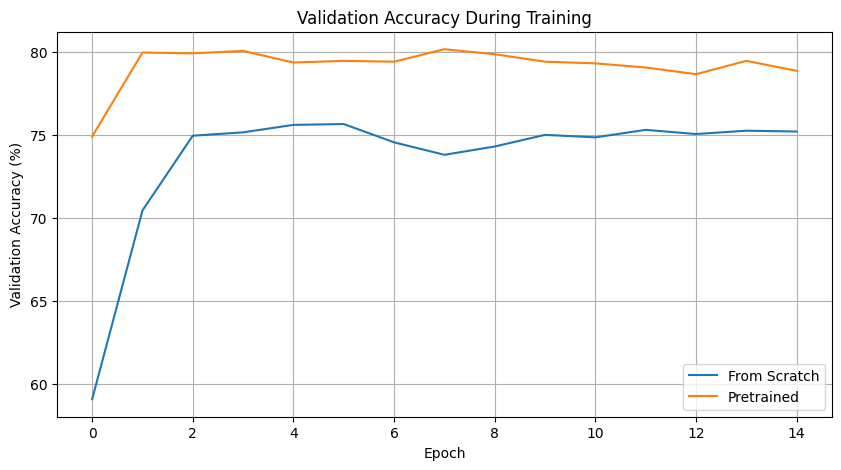

In [31]:
#Visualize the accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(from_scratch_valid_acc, label='From Scratch')

plt.plot(pretrained_valid_acc, label='Pretrained')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy During Training')
plt.legend()
plt.grid(True)
plt.show()
